In [2]:
import torch 
import torch.nn as nn
from preprocess import createVocabs, filterVocab,zeroPad, getLengthsOfQa, getResponseMask, qaPairsToTensors
from model import Encoder, Attention, AttentionDecoder
from utils import *

In [3]:
import random
import os
import matplotlib.pyplot as plt

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
print(f'Working on {device}')
# device = torch.device('cpu')
# print(f'Working on {device}')

Working on cuda


In [4]:
import torch 
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, embedding,embedding_size, hidden_size, num_layers, dropout_rate=0):
        super(Encoder, self).__init__()
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        #self.input_sizet_size  = input_size
        #self.embedding = nn.Embedding(self.input_size, self.embedding_size)
        self.embedding = embedding
        self.dropout_rate = dropout_rate
        if self.num_layers == 1: self.dropout_rate = 0
        self.gru_args = {'input_size':self.embedding_size, 'hidden_size': self.hidden_size, 
                    'num_layers': self.num_layers,'bidirectional':True, 'dropout':self.dropout_rate}
        self.gru = nn.GRU(**self.gru_args)
        
    def forward(self, query_seq, query_lengths, hidden_state = None):
        #getting the embeddings of out query
        #print(f'{1} Shape of input seq : {query_seq.size()}')
        query_seq_emb = self.embedding(query_seq)
        #print(f'{2} Shape of Emb output : {query_seq_emb.size()}')
        #we need to pack our padded sequence as it helps in reducing the computation by ignoring computation of padded token.
        query_seq_packed = nn.utils.rnn.pack_padded_sequence(query_seq_emb, query_lengths)
        
        outputs, hidden_state = self.gru(query_seq_packed, hidden_state)
        #now we need to unpack

        outputs,_ =  nn.utils.rnn.pad_packed_sequence(outputs)
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:]
        #print('enc output size : ',outputs.size())
        
        
        #print(f'{3} Shape of Enc GRU output : {outputs.size()}')
       # print(f'{4} Shape of Enc Hidden : {hidden_state.size()}')
        
        return outputs, hidden_state
        

class Attention(nn.Module):
    def __init__(self,score, hidden_size):
        super(Attention,self).__init__()
        self.score = score
        self.hidden_size = hidden_size
        #defining two fc layers: 
        #for general and dot score
        self.fc1 = nn.Linear(self.hidden_size, self.hidden_size)
        #for concat score (two times the input size because we concat ht and hs)
        self.fc2 = nn.Linear(self.hidden_size*2, self.hidden_size)
        self.v = nn.Parameter(torch.FloatTensor(self.hidden_size))
        self.softmax = nn.Softmax(dim=1)
        
    def getScore(self,target_hidden, source_hidden):
        """
        This method calculates the energies based on the score method passed for the luong attention mechanism.
        """
        if self.score == 'general':
            energy = self.fc1(source_hidden)
            #multiply these energies with hidden states of encoder
            weighted_hidden = energy*source_hidden
            energies = torch.sum(weighted_hidden, dim=2)
        elif self.score == 'dot':
            #energy = self.fc2(source_hidden)
            #multiply these energies with hidden states of encoder
            weighted_hidden = target_hidden*source_hidden
            energies =  torch.sum(weighted_hidden, dim=2)
            
        elif self.score == 'concat':
            #torch.cat((hidden.expand(encoder_output.size(0), -1, -1), encoder_output), 2)
            # if target_hidden.size() != source_hidden.size():
            #     target_hidden.expand(source_hidden.size(0),-1,-1)
            
            energy = self.fc2(torch.cat((target_hidden.expand(source_hidden.size(0), -1, -1), source_hidden), 2)).tanh()

            
#             #v = v.to(device)
#             weighted_hidden = energy*v
#             energies = torch.sum(weighted_hidden, dim=2)
            energies = torch.sum(self.v * energy, dim=2)
            
        return energies.t()
        
    def forward(self,target_hidden, source_hidden):
        """
        args: target_hideen => the output of the decoder rnn
              source_hidden => the output of encoder
        """
        x = self.getScore(target_hidden, source_hidden)
        x = self.softmax(x)
        
        return x.unsqueeze(1)
        
    
    
        
    
    
class AttentionDecoder(nn.Module):
    def __init__(self, attention_method, embedding, embedding_size, hidden_size, output_size,num_layers, dropout_rate=0.2):
        super(AttentionDecoder,self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_rate = dropout_rate
        self.num_layers = num_layers #Note: This needs to be experimented
        self.attention_method = attention_method #Experiment with it
        self.embedding_size = embedding_size
        #initialize the embedding layer
        self.embedding = embedding
        
        #initialize the GRU layer
        self.gru_args = {'input_size':self.embedding_size, 'hidden_size': self.hidden_size, 
                    'num_layers': self.num_layers}
        self.gru = nn.GRU(**self.gru_args)
        
        #initialize the fully connected layers
        self.fc1_args = {'in_features': 2*self.hidden_size, 'out_features': self.hidden_size}
        self.fc1 = nn.Linear(**self.fc1_args) 
        self.fc2_args = {'in_features': self.hidden_size, 'out_features': self.output_size}
        self.fc2 = nn.Linear(**self.fc2_args)
        
        #initialize attention:
        self.attention = Attention(self.attention_method, self.hidden_size)
        
        #final softmax
        self.softmax = nn.Softmax( dim=1)
        
    def forward(self,x, hidden_state, encoder_output):
        #shape of x : (1,batch_size)
        x_embd = self.embedding(x)
        #shape : 
        #print(f'emb shape : {x_embd.size()}')
        gru_output,curr_hidden_state = self.gru(x_embd, hidden_state)
        #print(f'dec gru op : {gru_output.size()} // hidden : {curr_hidden_state.size()}')
        #we will calculate the weights (alpha) of attention using Attention class
        alpha = self.attention(gru_output, encoder_output)
        #print('alpha size : ',alpha.size())
        #print(encoder_output.transpose(0,1).size())
        
        #now multiply these weight with encoder outputs:
        context = torch.bmm(alpha, encoder_output.transpose(0,1))
        
        #now that we have context vector and decoder output, we need to concatenate:
        x_out = torch.cat((gru_output.squeeze(0),context.squeeze(1)),1)
        #pass this x_out through a tanh activation:
        x_out = self.fc1(x_out)
        x_out = torch.tanh(x_out)
        x_out = self.fc2(x_out)
        x_out = self.softmax(x_out)
        return x_out, curr_hidden_state
                   

In [5]:
#ref: https://pytorch.org/tutorials/beginner/chatbot_tutorial.html
#(decoder_output, target_variable[t], mask[t])


def maskNLLLoss(inp_word, target_word, mask_word):

    #print(inp_word.size(), target_word.size())
    #print(mask_word.size())
    nTotal = mask_word.sum()
    crossEntropy = -torch.log(torch.gather(inp_word, 1, target_word.view(-1, 1)).squeeze(1))
    loss = crossEntropy.masked_select(mask_word).mean()
    loss = loss.to(device)

    return loss, nTotal.item()


In [6]:
def train(query, query_lengths, response, response_mask, max_response_len,encoder, decoder,
          encoder_optimizer, decoder_optimizer, batch_size, teacher_force_ratio, vocab_size, clip_grads = True):
    
    #initializations:
    tot_loss = 0
    n_totals = 0
    report_loss = []

    
    #setting the gradients to zero:
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    #load the data to device
    query = query.to(device)
    response = response.to(device)
    response_mask = response_mask.to(device)
    
    #our query and response is of size (batch, max_len) but we want it to be (max_len, batch):
    query = query.t()
    response = response.t()
    response_mask = response_mask.t()
    #print(f'Shape of query : {query.size()}')
    #model
    #print(f'batch size : {batch_size}')
    
    ################=======================================================================###################
    #print(f'query response : {query.size()} {response.size()}')
     
    encoder_outputs, hidden = encoder(query, query_lengths)

    #initialize decoders first hidden state as enocers last hidden output

    curr_hidden_state = hidden[:decoder.num_layers]

    #initialize decoder input
    SOS_token = 1

    decoder_input = torch.LongTensor([[SOS_token for _ in range(batch_size)]])
    decoder_input = decoder_input.to(device)
    
    if random.random() < teacher_force_ratio:
        for t in range(max_response_len):
            #print(f'token {t} dec input : {decoder_input.size()} encoder op size : {encoder_outputs.size()}, enc hidden size : {curr_hidden_state.size()}')
            dec_out, curr_hidden_state = decoder(decoder_input, curr_hidden_state, encoder_outputs)
            #print(f'response : {response.size()}, response_mask : {response_mask.size()}')
            decoder_input = response[t].view(1,-1)
            mask_loss, nTotal = maskNLLLoss(dec_out, response[t], response_mask[t])
            tot_loss += mask_loss
            report_loss.append(mask_loss.item() * nTotal)
            n_totals += nTotal
            
    else:
         for t in range(max_response_len):
            #print(f'token {t} dec input : {decoder_input.size()} encoder op size : {encoder_outputs.size()}, enc hidden size : {curr_hidden_state.size()}')
            dec_out, curr_hidden_state = decoder(decoder_input, curr_hidden_state, encoder_outputs)
            _, topi = dec_out.topk(1)
            decoder_input = torch.LongTensor([[topi[i][0] for i in range(batch_size)]])
            decoder_input = decoder_input.to(device)
            
            mask_loss, nTotal = maskNLLLoss(dec_out, response[t], response_mask[t])
            tot_loss += mask_loss
            report_loss.append(mask_loss.item() * nTotal)
            n_totals += nTotal
    
    ################=======================================================================###################
    
    tot_loss.backward()
    
    if clip_grads:
        _ = nn.utils.clip_grad_norm_(encoder.parameters(), 50.0)
        _ = nn.utils.clip_grad_norm_(decoder.parameters(), 50.0)
        
    encoder_optimizer.step()
    decoder_optimizer.step()
    avg_loss = sum(report_loss)/n_totals
    return avg_loss
    
    

In [7]:
def train_0(query, query_lengths, response, response_mask, max_response_len,encoder, decoder,
          encoder_optimizer, decoder_optimizer, batch_size, teacher_force_ratio, vocab_size, clip_grads = True):
    
    #initializations:
    tot_loss = 0
    n_totals = 0
    report_loss = []

    
    #setting the gradients to zero:
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    #load the data to device
    query = query.to(device)
    response = response.to(device)
    response_mask = response_mask.to(device)
    
    #our query and response is of size (batch, max_len) but we want it to be (max_len, batch):
    query = query.t()
    response = response.t()
    response_mask = response_mask.t()
    #print(f'Shape of query : {query.size()}')
    #model
    #print(f'batch size : {batch_size}')
    
    ################=======================================================================###################
    #print(f'query response : {query.size()} {response.size()}')
     
    encoder_outputs, hidden = encoder(query, query_lengths)

    #initialize decoders first hidden state as enocers last hidden output

    curr_hidden_state = hidden[:decoder.num_layers]

    #initialize decoder input
    SOS_token = 1

    decoder_input = torch.LongTensor([[SOS_token for _ in range(batch_size)]])
    decoder_input = decoder_input.to(device)
    
   

    for t in range(max_response_len):
        #print(f'token {t} dec input : {decoder_input.size()} encoder op size : {encoder_outputs.size()}, enc hidden size : {curr_hidden_state.size()}')
        dec_out, curr_hidden_state = decoder(decoder_input, curr_hidden_state, encoder_outputs)
        #print(f'response : {response.size()}, response_mask : {response_mask.size()}')
        mask_loss, nTotal = maskNLLLoss(dec_out, response[t], response_mask[t])
        tot_loss += mask_loss
        report_loss.append(mask_loss.item() * nTotal)
        n_totals += nTotal
        
        if random.random() < teacher_force_ratio: 
            decoder_input = response[t].view(1,-1)
        else:
            _, topi = dec_out.topk(1)
            decoder_input = torch.LongTensor([[topi[i][0] for i in range(batch_size)]])
            decoder_input = decoder_input.to(device)
            #print(f'using dec ip : {decoder_input.size()}')
    
    ################=======================================================================###################
    
  
    tot_loss.backward()
    
    if clip_grads:
        _ = nn.utils.clip_grad_norm_(encoder.parameters(), 50.0)
        _ = nn.utils.clip_grad_norm_(decoder.parameters(), 50.0)
        
    encoder_optimizer.step()
    decoder_optimizer.step()
    avg_loss = sum(report_loss)/n_totals
    return avg_loss
    
    

In [8]:
def createBatches(vocab, qa_pair_batch, max_len):
    """
    This function takes a batch of qa_pairs (a list of lists, e.g. [['they do to !', 'they do not !'], 
                                                                    ['she okay ?', 'i hope so .'], 
                                                                    ['wow', 'let s go .']])
    And returns the tensor of indices for queries, reponses and also the lengths of all the queries,
    and the mask tensor of responses and the max length in the responses.
    """

    #shape of batched input: (max_length, batch_size)
    #reverse sorting based on the length of sentences
    #print(qa_pair_batch)
    qa_pair_batch.sort(key=lambda x: len(x[0].split(" ")), reverse=True)
    #print(qa_pair_batch)

    q_batch_lengths, r_batch_lengths = getLengthsOfQa(qa_pair_batch)
    q_batch_tensors, r_batch_tensors = qaPairsToTensors(qa_pair_batch, vocab, max_len)
    r_batch_mask = getResponseMask(r_batch_tensors)

    max_r_length = max(r_batch_lengths)

    return q_batch_tensors, q_batch_lengths, r_batch_tensors, r_batch_mask, max_r_length

In [9]:
def saveModelCheckP(e,save_dir,encoder_n_layers, decoder_n_layers,hidden_size, vocab, avg_loss, embedding):
    
    directory = os.path.join(save_dir, 'chatbot', 
                             '{}-{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size))

    if not os.path.exists(directory):
        os.makedirs(directory)
        
    #saving our model in state_dict format:
    torch.save({
        'epoch': e,
        'en': encoder.state_dict(),
        'de': decoder.state_dict(),
        'en_opt': encoder_optimizer.state_dict(),
        'de_opt': decoder_optimizer.state_dict(),
        'loss': avg_loss,
        'voc_dict': vocab.__dict__,
        'embedding': embedding.state_dict()
    }, os.path.join(directory, '{}_{}.tar'.format(e, 'checkpoint')))

In [10]:


def trainEpochs(vocab, qa_pairs,max_len, encoder, decoder, encoder_optimizer, decoder_optimizer, embedding,
                num_layers_encoder, num_layers_decoder,hidden_size, destination_path, epochs, batch_size, teacher_force_ratio,load_file=False):
    train_batches = []
    tr_losses = []
    for e in range(epochs):
        #print(e)
        cur_batch = []
        for _ in range(batch_size):
            qa_pair_batch = random.choice(qa_pairs)
            cur_batch.append(qa_pair_batch)
        train_batches.append(createBatches(vocab, cur_batch, max_len))
        
    start_epoch = 1
    if load_file:
        start_epoch = saved_model['epoch'] + 1
        end_epoch = start_epoch + epochs
    
    total_loss = 0
    clip_grads = True
    for e in range(1, epochs + 1):
        #geting the eth batch and unfolding the values:
        curr_batch = train_batches[e-1]
        q_batch_tensors, q_batch_lengths, r_batch_tensors, r_batch_mask, max_r_length = curr_batch
        #print(f'Epoch : {e}')
        #calling the train fucntion:
        tr_args = [q_batch_tensors, q_batch_lengths, r_batch_tensors, r_batch_mask, max_r_length, encoder, decoder,
          encoder_optimizer, decoder_optimizer, batch_size, teacher_force_ratio, 
          vocab_size, clip_grads]
        
        avg_loss = train(*tr_args)
        #print('reached here')
        total_loss += avg_loss
        tr_losses.append(total_loss/e)
        print(f'Epoch : {e} || Loss : {total_loss/e}')
        if e%1000 == 0:
            #print(f'Epoch : {e} || Loss : {total_loss/e}')
            #saving the state dicts:
            saveModelCheckP(e,destination_path, num_layers_encoder, num_layers_decoder,hidden_size, vocab, avg_loss, embedding)
    
    return tr_losses
    # plt.plot(range(1, epochs+1), tr_losses)
    # plt.xlabel('Epochs')
    # plt.ylabel('Loss')
    # plt.show()

In [11]:
#defining preprocessing inputs

max_len = 10
#min_freq = 2
vocab,qa_pairs = createVocabs('training.txt', max_len)
#filterVocab(vocab,qa_pairs, min_freq)
quers,resps = qaPairsToTensors(qa_pairs, vocab, max_len)

In [62]:
qa_pairs[:20]

[['they do to !', 'they do not !'],
 ['she okay ?', 'i hope so .'],
 ['wow', 'let s go .'],
 ['what good stuff ?', 'the real you .'],
 ['the real you .', 'like my fear of wearing pastels ?'],
 ['do you listen to this crap ?', 'what crap ?'],
 ['well no . . .', 'then that s all you had to say .'],
 ['then that s all you had to say .', 'but'],
 ['but', 'you always been this selfish ?'],
 ['have fun tonight ?', 'tons'],
 ['you know chastity ?', 'i believe we share an art instructor'],
 ['hi .', 'looks like things worked out tonight huh ?'],
 ['you have my word . as a gentleman', 'you re sweet .'],
 ['there .', 'where ?'],
 ['great', 'would you mind getting me a drink cameron ?'],
 ['who ?', 'joey .'],
 ['did you change your hair ?', 'no .'],
 ['no .', 'you might wanna think about it'],
 ['hey sweet cheeks .', 'hi joey .'],
 ['it s more', 'expensive ?']]

In [12]:
print(f'Total Pairs : {len(qa_pairs)}')
print(f'Vocab Size : {vocab.counter}')

size_tr_data = len(qa_pairs)
vocab_size = vocab.counter

Total Pairs : 64313
Vocab Size : 18080


In [13]:
#now defining all the variables:


#encoder args => embedding, hidden_size, num_layers, dropout_rate=0
hidden_size = 512
enc_embedding_size = 512
enc_num_layers = 2
enc_drop_rate = 0.1

#decoder args => attention_method,input_size, embedding_size, hidden_size, output_size,num_layers, dropout_rate=0.2
attention_method = 'dot'
#attention_method = 'general'
#attention_method = 'concat'
input_size = vocab_size
hidden_size = 512
dec_embedding_size = 512
dec_n_layers = 2

dec_drop_rate = 0.1
batch_size = 1024

#defining output size which will be same as our input_size which is len_vocabs
output_size = vocab_size
  
#defining embeddings:
enc_embedding = nn.Embedding(vocab_size, enc_embedding_size )
dec_embedding = nn.Embedding(vocab_size, dec_embedding_size )

#embedding,embedding_size, hidden_size, num_layers, dropout_rate=0
encoder = Encoder(enc_embedding,enc_embedding_size, hidden_size, enc_num_layers, enc_drop_rate)
#attention_method,input_size, embedding, embedding_size, hidden_size, output_size,num_layers, dropout_rate=0.2
decoder = AttentionDecoder(attention_method, dec_embedding, dec_embedding_size, hidden_size, output_size,
                           dec_n_layers, dec_drop_rate)


#logic to load the saved model:
#load_model = 'saved_models/chatbot/2-2_512/10000_checkpoint.tar'
load_model = None
if load_model:
    saved_model = torch.load(load_model)
    encoder_ = saved_model['en']
    decoder_ = saved_model['de']
    
    encoder.load_state_dict(encoder_)
    decoder.load_state_dict(decoder_)
    
    
    encoder_optimizer_ = saved_model['en_opt']
    decoder_optimizer_ = saved_model['de_opt']
    
    
    embedding_ = saved_model['embedding']
    enc_embedding.load_state_dict(embedding_)
    dec_embedding.load_state_dict(embedding_)
    vocab.__dict__ = saved_model['voc_dict']
    
    

encoder = encoder.to(device)
decoder = decoder.to(device)

In [14]:
epochs = 2000
learning_rate = 0.0001
decoder_learning_ratio = 5.0
teacher_force_ratio = 1.0
destination_path = 'saved_models/'
clip = 50.0

encoder.train()
decoder.train()

encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)

if load_model:
    encoder_optimizer.load_state_dict(encoder_optimizer_)
    decoder_optimizer.load_state_dict(decoder_optimizer_)

for state in encoder_optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.cuda()

for state in decoder_optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.cuda()
            


            

In [15]:
# train_epoch_args = [vocab, qa_pairs, max_len, encoder, decoder, encoder_optimizer, decoder_optimizer, embedding,
#                     num_layers_encoder, num_layers_decoder, destination_path, epochs, batch_size, 
#                     teacher_force_ratio,load_file=False]

tr_losses = trainEpochs(vocab, qa_pairs, max_len, encoder, decoder, encoder_optimizer, decoder_optimizer, enc_embedding,
                enc_num_layers, dec_n_layers,hidden_size, destination_path, epochs, batch_size, teacher_force_ratio, load_model)

Epoch : 1 || Loss : 9.816549576868598
Epoch : 2 || Loss : 9.75677734199325
Epoch : 3 || Loss : 9.675457849019843
Epoch : 4 || Loss : 9.5618734082943
Epoch : 5 || Loss : 9.402667408673395
Epoch : 6 || Loss : 9.194755761784416
Epoch : 7 || Loss : 8.940949796862522
Epoch : 8 || Loss : 8.68291114257191
Epoch : 9 || Loss : 8.445701106996097
Epoch : 10 || Loss : 8.231146886065178
Epoch : 11 || Loss : 8.034448529065951
Epoch : 12 || Loss : 7.861500919364541
Epoch : 13 || Loss : 7.698846099413923
Epoch : 14 || Loss : 7.552380651575757
Epoch : 15 || Loss : 7.4207012330836815
Epoch : 16 || Loss : 7.301003027641699


KeyboardInterrupt: 

# Evaluation using Greedy Search

In [14]:

class GreedyDecoder(nn.Module):
    def __init__(self,encoder, decoder):
        super(GreedyDecoder,self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.decoder_n_layer = self.decoder.num_layers
    #query, response, query_lengths, vocab_size,teacher_force_ratio)
    def forward(self, query, query_lengths, max_len):

        encoder_outputs, hidden = self.encoder(query, query_lengths)
        
        #initialize decoders first hidden state as enocers last hidden output
        decoder_input_hidden = hidden[:self.decoder_n_layer]
        
        #initialize decoder input
        SOS_token = 1
        decoder_input = torch.ones(1, 1, device=device, dtype=torch.long) * SOS_token
        
        #initialize genearted token and scores tensors
        generated_tokens = torch.zeros([0], device=device, dtype=torch.long)
        generated_scores = torch.zeros([0], device=device)
        
        for t in range(max_len):
            #print(f'token {t} dec input : {decoder_input.size()} encoder op size : {encoder_outputs.size()}, enc hidden size : {curr_hidden_state.size()}')
            dec_out, decoder_input_hidden = decoder(decoder_input, decoder_input_hidden, encoder_outputs)
            
            # fetching the most probable word using the softmax scores:
            #print(dec_out.topk(5))
            #topi = np.random.permutation(int(len(de)/10)) 
            scores, decoder_input = torch.max(dec_out, dim=1)
            
            # concatenating the tokens and scores
            generated_tokens = torch.cat((generated_tokens, decoder_input), dim=0)
            generated_scores = torch.cat((generated_scores, scores), dim=0)
            
            #preparing the current token to be the input for decoder:
            decoder_input = torch.unsqueeze(decoder_input, 0)

            
        return generated_tokens,  generated_scores   

In [24]:
"""
1. format the sentence as an input batch
2. convert the words of the sentence to their corresponding indexes
3. transposing the dimensions
4. create a lengths tensor which contains the length of our input sentence
5. obtain the decoded response sentence tensor using our GreedySearchDecoder
6.  convert the response’s indexes to words
7. return
"""


def getResponse(query, encoder, decoder, model, vocab, max_len):
    
    word2idx = vocab.word2idx
    idx2word = vocab.idx2word
    query_tokens = []
    queries = []
    query += ' ' + 'eos'
    query_tokens = []
    for word in query.split(' '):
        query_tokens.append(word2idx[word])
        
    queries.append(query_tokens)
    query_tensor = torch.LongTensor(queries).transpose(0,1)
    lengths_tensor = torch.tensor([len(q) for q in queries])
    
    #loading the tensors on device:
    query_tensor = query_tensor.to(device)
    lengths_tensor = lengths_tensor.to('cpu')
    
    #passing the tensors through our searcher model

    gen_tokens, gen_scores = model(query_tensor, lengths_tensor, max_len)
    
    return [idx2word[idx.item()] for idx in gen_tokens]
    
    
from beam import beam_search_decoding, batch_beam_search_decoding


def getResponseBeam(query, encoder, decoder, vocab, max_len):
    
    word2idx = vocab.word2idx
    idx2word = vocab.idx2word
    query_tokens = []
    queries = []
    query += ' ' + 'eos'
    query_tokens = []
    for word in query.split(' '):
        query_tokens.append(word2idx[word])
        
    queries.append(query_tokens)
    query_tensor = torch.LongTensor(queries).transpose(0,1)
    lengths_tensor = torch.tensor([len(q) for q in queries])
    
    #loading the tensors on device:
    query_tensor = query_tensor.to(device)
    lengths_tensor = lengths_tensor.to('cpu')
    
    #passing the tensors through our searcher model
    encoder_outputs, hidden = encoder(query_tensor, lengths_tensor)
    print(encoder_outputs.size())
    gen_tokens = batch_beam_search_decoding(decoder,
                                                enc_outs=encoder_outputs,
                                                enc_last_h=hidden,
                                                beam_width=3,
                                                n_best=1,
                                                sos_token=1,
                                                eos_token=2,
                                                max_dec_steps=1000,
                                                device=device)

    
    return [idx2word[idx.item()] for idx in gen_tokens]
    
    
    



def evaluateQuery(encoder, decoder, method, vocab, max_len):
    query = ''
    while(1):
        #try:
        query = input('> ')
        if query == 'q' or query == 'quit': break

        query = convertUnicodeToASCII(query)
        query = cleanString(query)
        if method == 'greedy':
            model = GreedyDecoder(encoder, decoder)
            output = getResponse(query, encoder, decoder, model, vocab, max_len)
        
        if method == 'beam':
            output = getResponseBeam(query, encoder, decoder, vocab, max_len)
        else:
            print('Please specify greedy or beam search methoda!')

        response = []
        for word in output:
            if word not in ['sos', 'eos', 'pad']:
                response.append(word)

        print('Bot : ',' '.join(response))
            
            
            
        # except KeyError:
        #     print('Sorry! I could not get you.')
        
    
    

In [25]:

encoder.eval()
decoder.eval()
method = 'beam'

# Begin chatting (uncomment and run the following line to begin)
evaluateQuery(encoder, decoder, method, vocab, max_len)

>  hi


torch.Size([2, 1, 512])


RuntimeError: input must have 3 dimensions, got 2

In [19]:

encoder.eval()
decoder.eval()

# Initialize search module
#model = BeamDecoder(encoder, decoder,3)

# Begin chatting (uncomment and run the following line to begin)
evaluateQuery(encoder, decoder, model, vocab, max_len)

>  hi


torch.Size([2, 1, 512])


RuntimeError: input must have 3 dimensions, got 2

# Experiments

In [29]:
#embed size = 256
dot_tr_losses = trainEpochs(vocab, qa_pairs, max_len, encoder, decoder, encoder_optimizer, decoder_optimizer, enc_embedding,
                enc_num_layers, dec_n_layers,hidden_size, destination_path, epochs, batch_size, teacher_force_ratio, load_model)

Epoch : 1 || Loss : 9.793815068920347
Epoch : 2 || Loss : 9.753500613630766
Epoch : 3 || Loss : 9.694357949157242
Epoch : 4 || Loss : 9.631574561633204
Epoch : 5 || Loss : 9.52670925684614
Epoch : 6 || Loss : 9.366246274693072
Epoch : 7 || Loss : 9.14796699055042
Epoch : 8 || Loss : 8.915462859938597
Epoch : 9 || Loss : 8.68348114426989
Epoch : 10 || Loss : 8.498166266522238
Epoch : 11 || Loss : 8.306958094346838
Epoch : 12 || Loss : 8.122766017804443
Epoch : 13 || Loss : 7.9662068432719755
Epoch : 14 || Loss : 7.826953777681537
Epoch : 15 || Loss : 7.7122605273263645
Epoch : 16 || Loss : 7.593488653668854
Epoch : 17 || Loss : 7.493486423828269
Epoch : 18 || Loss : 7.387514483794511
Epoch : 19 || Loss : 7.293703434031397
Epoch : 20 || Loss : 7.213959169559375
Epoch : 21 || Loss : 7.1308572412271785
Epoch : 22 || Loss : 7.058500911053966
Epoch : 23 || Loss : 6.976194778268943
Epoch : 24 || Loss : 6.907019152678551
Epoch : 25 || Loss : 6.8476279216411795
Epoch : 26 || Loss : 6.7983188622

In [87]:
#embed size = 512
tr_losses1 = trainEpochs(vocab, qa_pairs, max_len, encoder, decoder, encoder_optimizer, decoder_optimizer, enc_embedding,
                enc_num_layers, dec_n_layers,hidden_size, destination_path, epochs, batch_size, teacher_force_ratio, load_model)

Epoch : 1 || Loss : 9.815590098961112
Epoch : 2 || Loss : 9.764117660522853
Epoch : 3 || Loss : 9.69666868187738
Epoch : 4 || Loss : 9.572198045063669
Epoch : 5 || Loss : 9.379829422465125
Epoch : 6 || Loss : 9.168189965076195
Epoch : 7 || Loss : 8.952336764849777
Epoch : 8 || Loss : 8.733531659670852
Epoch : 9 || Loss : 8.528782003044387
Epoch : 10 || Loss : 8.331346487690555
Epoch : 11 || Loss : 8.157077673570567
Epoch : 12 || Loss : 7.991005821805538
Epoch : 13 || Loss : 7.8687363299310595
Epoch : 14 || Loss : 7.765665869521837
Epoch : 15 || Loss : 7.650276908797067
Epoch : 16 || Loss : 7.527779299209939
Epoch : 17 || Loss : 7.436467753843592
Epoch : 18 || Loss : 7.341671816417133
Epoch : 19 || Loss : 7.2472087952715905
Epoch : 20 || Loss : 7.152795941895714
Epoch : 21 || Loss : 7.062515120865191
Epoch : 22 || Loss : 6.9838809394214705
Epoch : 23 || Loss : 6.9100015158469885
Epoch : 24 || Loss : 6.8439847880752565
Epoch : 25 || Loss : 6.7783962051394795
Epoch : 26 || Loss : 6.721671

In [90]:

tr_losses0 = trainEpochs(vocab, qa_pairs, max_len, encoder, decoder, encoder_optimizer, decoder_optimizer, enc_embedding,
                enc_num_layers, dec_n_layers,hidden_size, destination_path, epochs, batch_size, teacher_force_ratio, load_model)

Epoch : 1 || Loss : 9.78936939797503
Epoch : 2 || Loss : 9.747750327234634
Epoch : 3 || Loss : 9.688221971704413
Epoch : 4 || Loss : 9.61748772600597
Epoch : 5 || Loss : 9.516108051185128
Epoch : 6 || Loss : 9.404827322447558
Epoch : 7 || Loss : 9.225127722887924
Epoch : 8 || Loss : 9.012183904308047
Epoch : 9 || Loss : 8.821367220191984
Epoch : 10 || Loss : 8.661732863007995
Epoch : 11 || Loss : 8.468585357522269
Epoch : 12 || Loss : 8.304830713597452
Epoch : 13 || Loss : 8.1407029134505
Epoch : 14 || Loss : 7.993513399520637
Epoch : 15 || Loss : 7.883202604345824
Epoch : 16 || Loss : 7.783136809404293
Epoch : 17 || Loss : 7.678685558949354
Epoch : 18 || Loss : 7.558461270163111
Epoch : 19 || Loss : 7.459515837122458
Epoch : 20 || Loss : 7.369008562203787
Epoch : 21 || Loss : 7.280115372585036
Epoch : 22 || Loss : 7.201308581281617
Epoch : 23 || Loss : 7.12776703590048
Epoch : 24 || Loss : 7.048546013388634
Epoch : 25 || Loss : 6.992467068885255
Epoch : 26 || Loss : 6.9333237430722585

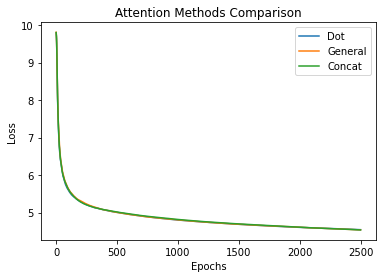

In [82]:
plt.plot(dot_tr_losses, label = 'Dot')
plt.plot(general_tr_losses, label = 'General')
plt.plot(concat_tr_losses, label = 'Concat')
plt.legend()
plt.title('Attention Methods Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

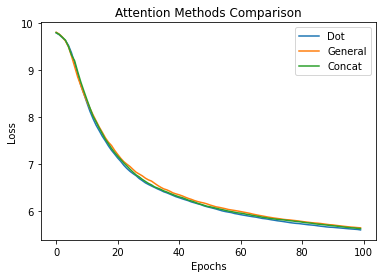

In [83]:
plt.plot(dot_tr_losses[:100], label = 'Dot')
plt.plot(general_tr_losses[:100], label = 'General')
plt.plot(concat_tr_losses[:100], label = 'Concat')
plt.legend()
plt.title('Attention Methods Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

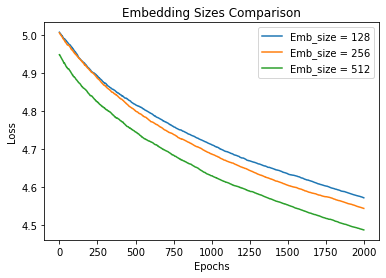

In [92]:
plt.plot(tr_losses0[500:], label = 'Emb_size = 128')
plt.plot(dot_tr_losses[500:], label = 'Emb_size = 256')
plt.plot(tr_losses1[500:], label = 'Emb_size = 512')
plt.legend()
plt.title('Embedding Sizes Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [49]:
tf1 = tr_losses.copy()

In [37]:
tf2 = tr_losses.copy()

In [43]:
tf3 = tr_losses.copy()

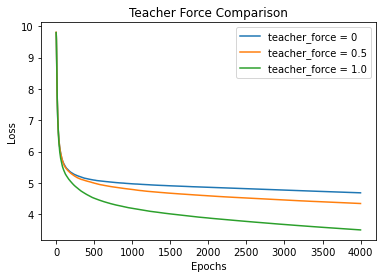

In [50]:
plt.plot(tf1[:], label = 'teacher_force = 0')
plt.plot(tf2[:], label = 'teacher_force = 0.5')
plt.plot(tf3[:], label = 'teacher_force = 1.0')
plt.legend()
plt.title('Teacher Force Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [24]:
tf64 = tr_losses.copy()

In [20]:
tf256 = tr_losses.copy()

In [16]:
tf1024 = tr_losses.copy()

In [28]:
tf64

[9.817250770568847,
 9.761794502666291,
 9.684232707537738,
 9.584108758876084,
 9.43242406917362,
 9.241241355210976,
 8.995259783331996,
 8.734976402703538,
 8.513586771901295,
 8.348124742545469,
 8.162558370558381,
 8.013721217676913,
 7.913779379160687,
 7.792084297067303,
 7.696428932169314,
 7.587491993246701,
 7.479949323729754,
 7.378680987146903,
 7.27505133704777,
 7.192576275293627,
 7.118199077324993,
 7.05014739129272,
 6.97585966024169,
 6.907959072743256,
 6.84360748524967,
 6.776239610461526,
 6.722028659980645,
 6.674313537682183,
 6.627422020085617,
 6.577248018480146,
 6.530008606800397,
 6.477776341629855,
 6.439516964958237,
 6.396527849822407,
 6.351277732670722,
 6.310867036821647,
 6.275896428199032,
 6.24315202356369,
 6.212596852914387,
 6.185002060625711,
 6.159079219765204,
 6.136163902765516,
 6.111518160341681,
 6.086488161927561,
 6.055328925012633,
 6.034258863935923,
 6.010649734773642,
 5.98579948527776,
 5.965531307024389,
 5.943275999921586,
 5.9273

In [27]:
tf256

[9.818754061712596,
 9.758563333663137,
 9.683601969144808,
 9.583306203927528,
 9.432943720954482,
 9.236996633218142,
 9.00532683059105,
 8.780526962355763,
 8.562201694809954,
 8.361306260354251,
 8.174377088270393,
 7.997258608823036,
 7.838548805428439,
 7.692138673275278,
 7.562525180866912,
 7.4382864219151905,
 7.318005592906166,
 7.206510228596105,
 7.103822465788596,
 7.012554062333568,
 6.928048047640281,
 6.849620682036044,
 6.779660835105895,
 6.712301088062521,
 6.643779855180154,
 6.577752436412813,
 6.516285163496741,
 6.460661767511185,
 6.409780040214104,
 6.360324570627806,
 6.317002525238401,
 6.276446141382227,
 6.236200471943523,
 6.202554488126444,
 6.165320792604855,
 6.136504175814192,
 6.106231109179746,
 6.079277543509121,
 6.051561157005713,
 6.023966536958667,
 5.998084576851956,
 5.973989209620017,
 5.950745672453558,
 5.926761319983791,
 5.902446178236068,
 5.880864124912452,
 5.85945829862275,
 5.840249511349762,
 5.821006817364124,
 5.803577399887813,
 

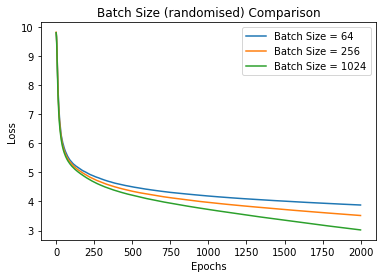

In [25]:
plt.plot(tf64[:], label = 'Batch Size = 64')
plt.plot(tf256[:], label = 'Batch Size = 256')
plt.plot(tf1024[:], label = 'Batch Size = 1024')
plt.legend()
plt.title('Batch Size (randomised) Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [64]:

class BeamDecoder(nn.Module):
    def __init__(self,encoder, decoder,k):
        super(BeamDecoder,self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.decoder_n_layer = self.decoder.num_layers
        self.k = k
    #query, response, query_lengths, vocab_size,teacher_force_ratio)
    def forward(self, query, query_lengths, max_len):

        encoder_outputs, hidden = self.encoder(query, query_lengths)
        
        #initialize decoders first hidden state as encoders last hidden output
        decoder_input_hidden = hidden[:self.decoder_n_layer]
        
        #initialize decoder input
        SOS_token = 1
        decoder_input = torch.ones(1, 1, device=device, dtype=torch.long) * SOS_token
        
        #initialize genearted token and scores tensors
        generated_tokens = torch.zeros([0], device=device, dtype=torch.long)
        generated_scores = torch.zeros([0], device=device)
        # generated_tokens = [[list(), 0.0]]
        generated_tokens = 
        print(generated_tokens)
            
        for t in range(max_len):
            all_candidates = list()
            #print(f'token {t} dec input : {decoder_input.size()} encoder op size : {encoder_outputs.size()}, enc hidden size : {curr_hidden_state.size()}')
            dec_out, decoder_input_hidden = decoder(decoder_input, decoder_input_hidden, encoder_outputs)
            print(dec_out, dec_out.size())
        
            for i in range(len(generated_tokens)):

                seq, score = generated_tokens[i]
                print(seq, score)
                for j in range(len(dec_out)):
                    candidate = [seq + dec_out[j], score - log(dec_out[j])]
                    all_candidates.append(candidate)
  
            ordered = sorted(all_candidates, key=lambda tup:tup[1])
            generated_tokens = ordered[:self.k]
            # concatenating the tokens and scores
          
            
        return generated_tokens,_

In [65]:

encoder.eval()
decoder.eval()

# Initialize search module
model = BeamDecoder(encoder, decoder,3)

# Begin chatting (uncomment and run the following line to begin)
evaluateQuery(encoder, decoder, model, vocab, max_len)

>  hi


tensor([], device='cuda:0', dtype=torch.int64)
tensor([[1.0580e-10, 1.0386e-08, 2.6084e-04,  ..., 7.7538e-09, 2.8982e-10,
         3.6981e-09]], device='cuda:0', grad_fn=<SoftmaxBackward0>) torch.Size([1, 18080])
tensor([[6.9914e-12, 1.0185e-08, 8.2651e-03,  ..., 1.6197e-09, 1.8329e-11,
         3.2220e-09]], device='cuda:0', grad_fn=<SoftmaxBackward0>) torch.Size([1, 18080])
tensor([[4.6498e-12, 1.0882e-08, 3.8261e-02,  ..., 1.2865e-09, 1.5713e-11,
         1.4551e-09]], device='cuda:0', grad_fn=<SoftmaxBackward0>) torch.Size([1, 18080])
tensor([[1.5190e-12, 3.7690e-09, 1.2325e-01,  ..., 1.5498e-09, 5.5345e-12,
         1.0050e-09]], device='cuda:0', grad_fn=<SoftmaxBackward0>) torch.Size([1, 18080])
tensor([[7.4896e-13, 2.1050e-09, 1.1785e-01,  ..., 7.3844e-10, 2.3806e-12,
         9.2342e-10]], device='cuda:0', grad_fn=<SoftmaxBackward0>) torch.Size([1, 18080])
tensor([[6.7217e-13, 2.1010e-09, 1.0381e-01,  ..., 5.0252e-10, 2.2428e-12,
         8.8988e-10]], device='cuda:0', grad_fn=

>  quit


In [22]:
# define a sequence of 10 words over a vocab of 5 words
import numpy as np
data = [[0.1, 0.2, 0.3, 0.4, 0.5],
 [0.5, 0.4, 0.3, 0.2, 0.1],
 [0.1, 0.2, 0.3, 0.4, 0.5],
 [0.5, 0.4, 0.3, 0.2, 0.1],
 [0.1, 0.2, 0.3, 0.4, 0.5],
 [0.5, 0.4, 0.3, 0.2, 0.1],
 [0.1, 0.2, 0.3, 0.4, 0.5],
 [0.5, 0.4, 0.3, 0.2, 0.1],
 [0.1, 0.2, 0.3, 0.4, 0.5],
 [0.5, 0.4, 0.3, 0.2, 0.1]]
data = np.array(data)

In [23]:
# beam search
def beam_search_decoder(data, k):
	sequences = [[list(), 0.0]]
	# walk over each step in sequence
	for row in data:
		all_candidates = list()
		# expand each current candidate
		for i in range(len(sequences)):
			seq, score = sequences[i]
			for j in range(len(row)):
				candidate = [seq + [j], score - log(row[j])]
				all_candidates.append(candidate)
		# order all candidates by score
		ordered = sorted(all_candidates, key=lambda tup:tup[1])
		# select k best
		sequences = ordered[:k]
	return sequences

In [24]:
from math import log
from numpy import array
from numpy import argmax

# beam search
def beam_search_decoder(data, k):
	sequences = [[list(), 0.0]]
	# walk over each step in sequence
	for row in data:
		all_candidates = list()
		# expand each current candidate
		for i in range(len(sequences)):
			seq, score = sequences[i]
			for j in range(len(row)):
				candidate = [seq + [j], score - log(row[j])]
				all_candidates.append(candidate)
		# order all candidates by score
		ordered = sorted(all_candidates, key=lambda tup:tup[1])
		# select k best
		sequences = ordered[:k]
	return sequences

# define a sequence of 10 words over a vocab of 5 words
data = [[0.1, 0.2, 0.3, 0.4, 0.5],
		[0.5, 0.4, 0.3, 0.2, 0.1],
		[0.1, 0.2, 0.3, 0.4, 0.5],
		[0.5, 0.4, 0.3, 0.2, 0.1],
		[0.1, 0.2, 0.3, 0.4, 0.5],
		[0.5, 0.4, 0.3, 0.2, 0.1],
		[0.1, 0.2, 0.3, 0.4, 0.5],
		[0.5, 0.4, 0.3, 0.2, 0.1],
		[0.1, 0.2, 0.3, 0.4, 0.5],
		[0.5, 0.4, 0.3, 0.2, 0.1]]
data = array(data)
# decode sequence
result = beam_search_decoder(data, 3)
# print result
for seq in result:
	print(seq)

[[4, 0, 4, 0, 4, 0, 4, 0, 4, 0], 6.931471805599453]
[[4, 0, 4, 0, 4, 0, 4, 0, 4, 1], 7.154615356913663]
[[4, 0, 4, 0, 4, 0, 4, 0, 3, 0], 7.154615356913663]
